In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to normalized Tensors. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [2]:
device = torch.device("cpu") # working locally with no GPU

# Define data transformation pipeline
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)     # True for first run

# Create data loader for training data with batch size 4 and shuffling
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)     # True for first run

# Create data loader for testing data with batch size 1 and shuffling
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define class labels for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
12500
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([4, 3, 32, 32])
truck frog horse plane

Test loader:
10000
{'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


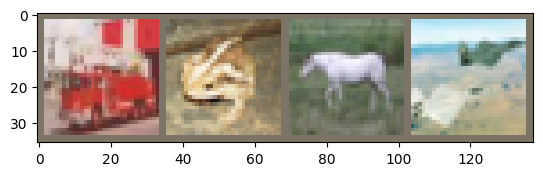

In [3]:
import matplotlib.pyplot as plt  
import numpy as np 
from collections import Counter  

# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display


# Function to display the 3 channels of an image  (Probably makes more sense in greyscale)
channels = ["Red channel", "Green channel", "Blue channel"]
cmaps = ["Reds","Greens","Blues"]
def imshow_channels(image):
    npimg = image.numpy()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes):
        ax.imshow(npimg[i], cmap=cmaps[i])  
        ax.set_title(channels[i])
        ax.axis('off')
    plt.show()

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainloader))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels  # 4 because it extracts a single batch!
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)
#imshow(images[0])
# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%s' % classes[labels[j]] for j in range(4)))  # Print labels for 4 images

# ------------------ Test Loader Section ------------------

print("\nTest loader:")

# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print(len(testloader))
print(new_stat)


2. Define a Convolution Neural Network.
[network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):                        
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers with increased width
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)                                       # MaxPool2d or AvgPool2d
        # Fully connected layers with increased width
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional layers with ... activation and max pooling            # relu, leaky_relu, rrelu, elu, celo, selu, gelu, silu, tanh,...
        x = self.pool(F.gelu(self.conv1(x)))
        x = self.pool(F.gelu(self.conv2(x)))
        x = self.pool(F.gelu(self.conv3(x)))
        # Flattening
        x = x.view(-1, 128 * 4 * 4)
        # Fully connected layers with ReLU activation
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))   
        # Output layer                            # Some random runs accuracies:
        x = self.fc3(x)                           # elu 75, relu leaky 74, relu 75, PReLU requires (learnable) weights, gelu 75
        return x

net = Net()
net.to(device)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

Compute the receptive field of the network

In [5]:
# This line attempts to clone a Git repository using a shell command.
!git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
!mv -v pytorch-receptive-field/torch_receptive_field ./

# Import the 'receptive_field' function from the 'torch_receptive_field' library.
from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
receptive_field(net, input_size=(3, 32, 32))


fatal: destination path 'pytorch-receptive-field' already exists and is not an empty directory.
mv: pytorch-receptive-field/torch_receptive_field: No such file or directory
------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0               [32, 32]        0.5        1.0             1.0 
        1               [32, 32]        0.5        1.0             3.0 
        2               [16, 16]        1.0        2.0             4.0 
        3               [16, 16]        1.0        2.0             8.0 
        4                 [8, 8]        2.0        4.0            10.0 
        5                 [8, 8]        2.0        4.0            18.0 
        6                 [4, 4]        4.0        8.0            22.0 


OrderedDict([('0',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 32, 32])])),
             ('1',
              OrderedDict([('j', 1.0),
                           ('r', 3.0),
                           ('start', 0.5),
                           ('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 32, 32, 32])])),
             ('2',
              OrderedDict([('j', 2.0),
                           ('r', 4.0),
                           ('start', 1.0),
                           ('input_shape', [-1, 32, 32, 32]),
                           ('output_shape', [-1, 32, 16, 16])])),
             ('3',
              OrderedDict([('j', 2.0),
                           ('r', 8.0),
                           ('start', 1.0),
                           ('input_shape', [-1, 32, 16, 16]),
         

3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



In [6]:
import torch.optim as optim  # Import the optim module from PyTorch for optimization algorithms

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)      # Best one

#optimizer = optim.Adam(net.parameters(), lr=0.0001)                  

# Explanation of the optimizer:
#   - optim.SGD(net.parameters(), lr=0.001, momentum=0.9):
#       - optim.SGD: This selects the Stochastic Gradient Descent (SGD) optimizer.
#       - net.parameters(): This provides the parameters of the network (`net`) to be optimized.
#       - lr=0.001: This sets the learning rate to 0.001 (controls how much the weights are updated).
#       - momentum=0.9: This sets the momentum to 0.9 (a technique to improve convergence).

4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Lists to store loss and accuracy values for each epoch
losses = []
accuracies = []
start_time = time.time()

num_print_intervals = 4  # Number of times to print statistics

num_print_intervals+=1
print_interval = int(len(trainloader) / num_print_intervals)

# Loop over the dataset multiple times (5 epochs in this case)
for epoch in range(5):
    running_loss = []  # Initialize a variable to track the total loss for this epoch
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the training data loader
    for i, data in enumerate(trainloader, 0):
        # Get the inputs (images) and labels from the current batch
        inputs, labels = data

        # Move the inputs and labels to the specified device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients accumulated in the previous iteration
        optimizer.zero_grad()

        # Training loop: forward pass, backward pass, and optimization
        # 1. Forward pass:
        outputs = net(inputs)  # Pass the input images through the network to get predictions (outputs)
        # 2. Calculate loss:
        loss = criterion(outputs, labels)  # Compute the loss based on the predictions (outputs) and ground truth labels
        # 3. Backward pass:
        loss.backward()  # Backpropagate the loss to calculate gradients for each parameter in the network
        # 4. Optimization step:
        optimizer.step()  # Update the weights and biases of the network based on the calculated gradients

        running_loss.append(loss.item())  # Accumulate the loss for this mini-batch

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if i > 0 and i % print_interval == 0:  # Check batch interval
            # Print the average loss for the mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, np.mean(running_loss)))
            # Reset the running loss for the next interval
            running_loss = []

    # Calculate accuracy for the epoch
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)
    losses.append(np.mean(running_loss))

# Training complete
end_time = time.time()
print(f"Trained in {end_time - start_time} seconds")

[1,  2501] loss: 2.2398
[1,  5001] loss: 1.7870
[1,  7501] loss: 1.4956
[1, 10001] loss: 1.3483
[2,  2501] loss: 1.1061
[2,  5001] loss: 1.0224
[2,  7501] loss: 0.9661
[2, 10001] loss: 0.9180
[3,  2501] loss: 0.7338
[3,  5001] loss: 0.7412
[3,  7501] loss: 0.7224
[3, 10001] loss: 0.7235
[4,  2501] loss: 0.5309
[4,  5001] loss: 0.5427
[4,  7501] loss: 0.5510
[4, 10001] loss: 0.5493
[5,  2501] loss: 0.3579
[5,  5001] loss: 0.3770
[5,  7501] loss: 0.3904
[5, 10001] loss: 0.4127
Trained in 596.7702820301056 seconds


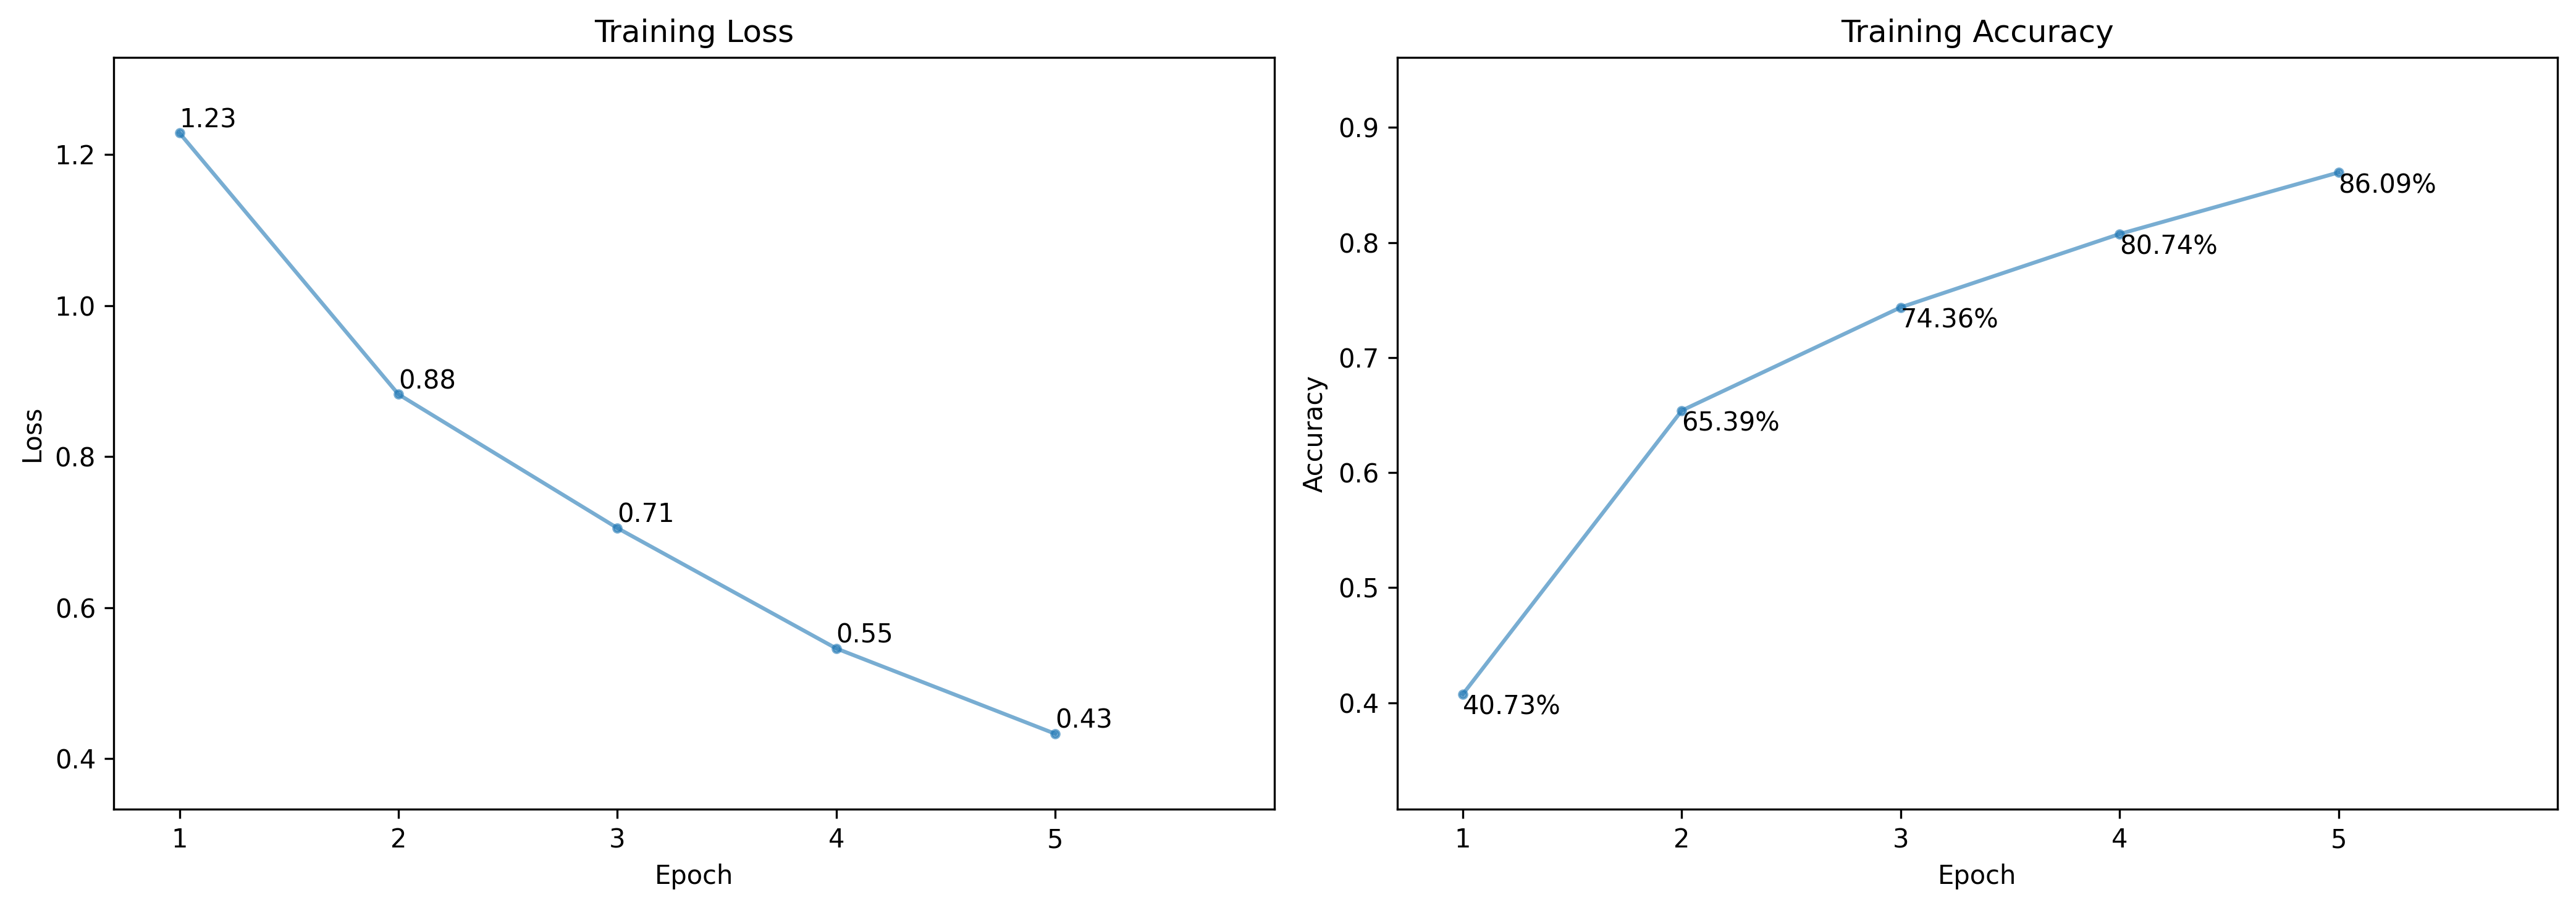

In [12]:
# Plotting training loss and accuracy curves

plt.figure(figsize=(14, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss', marker='o', markersize=3, alpha = 0.6)
for i, loss in enumerate(losses):
    plt.text(i, loss, f'{loss:.2f}', ha='left', va='bottom')
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(-0.3,5)
plt.ylim(min(losses)-0.1, max(losses)+0.1)
    
# rename the ticks to avoid epoch 0
plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5]) 
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy',marker='o', markersize=3, alpha = 0.6)
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy, f'{accuracy:.2%}', ha='left', va='top')
    
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xlim(-0.3,5)
plt.ylim(min(accuracies)-0.1, max(accuracies)+0.1)

plt.xticks([0, 1, 2, 3, 4], [1, 2, 3, 4, 5]) 
plt.title('Training Accuracy')

plt.tight_layout()
#plt.savefig('1.png', dpi = 300)   # Saves the plot
plt.show()

5. Test the network on the test data


We have trained the network for 5 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

In [9]:
# Initialize variables to track accuracy
correct = 0
total = 0

# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for data in testloader:
        # Get the image and label from the current batch
        image, label = data

        # Move the image data to the specified device 
        image = image.to(device)

        # Get the network's prediction for the image
        output = net(image)

        # Find the class with the highest probability
        _, predicted = torch.max(output.cpu(), 1)  

        # Update total number of test images
        total += label.size(0)  

        # Count correct predictions
        correct += (predicted == label).sum().item()  # Count true positives

# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 75 %


In [10]:
# With decimals

100 * correct / total

75.55

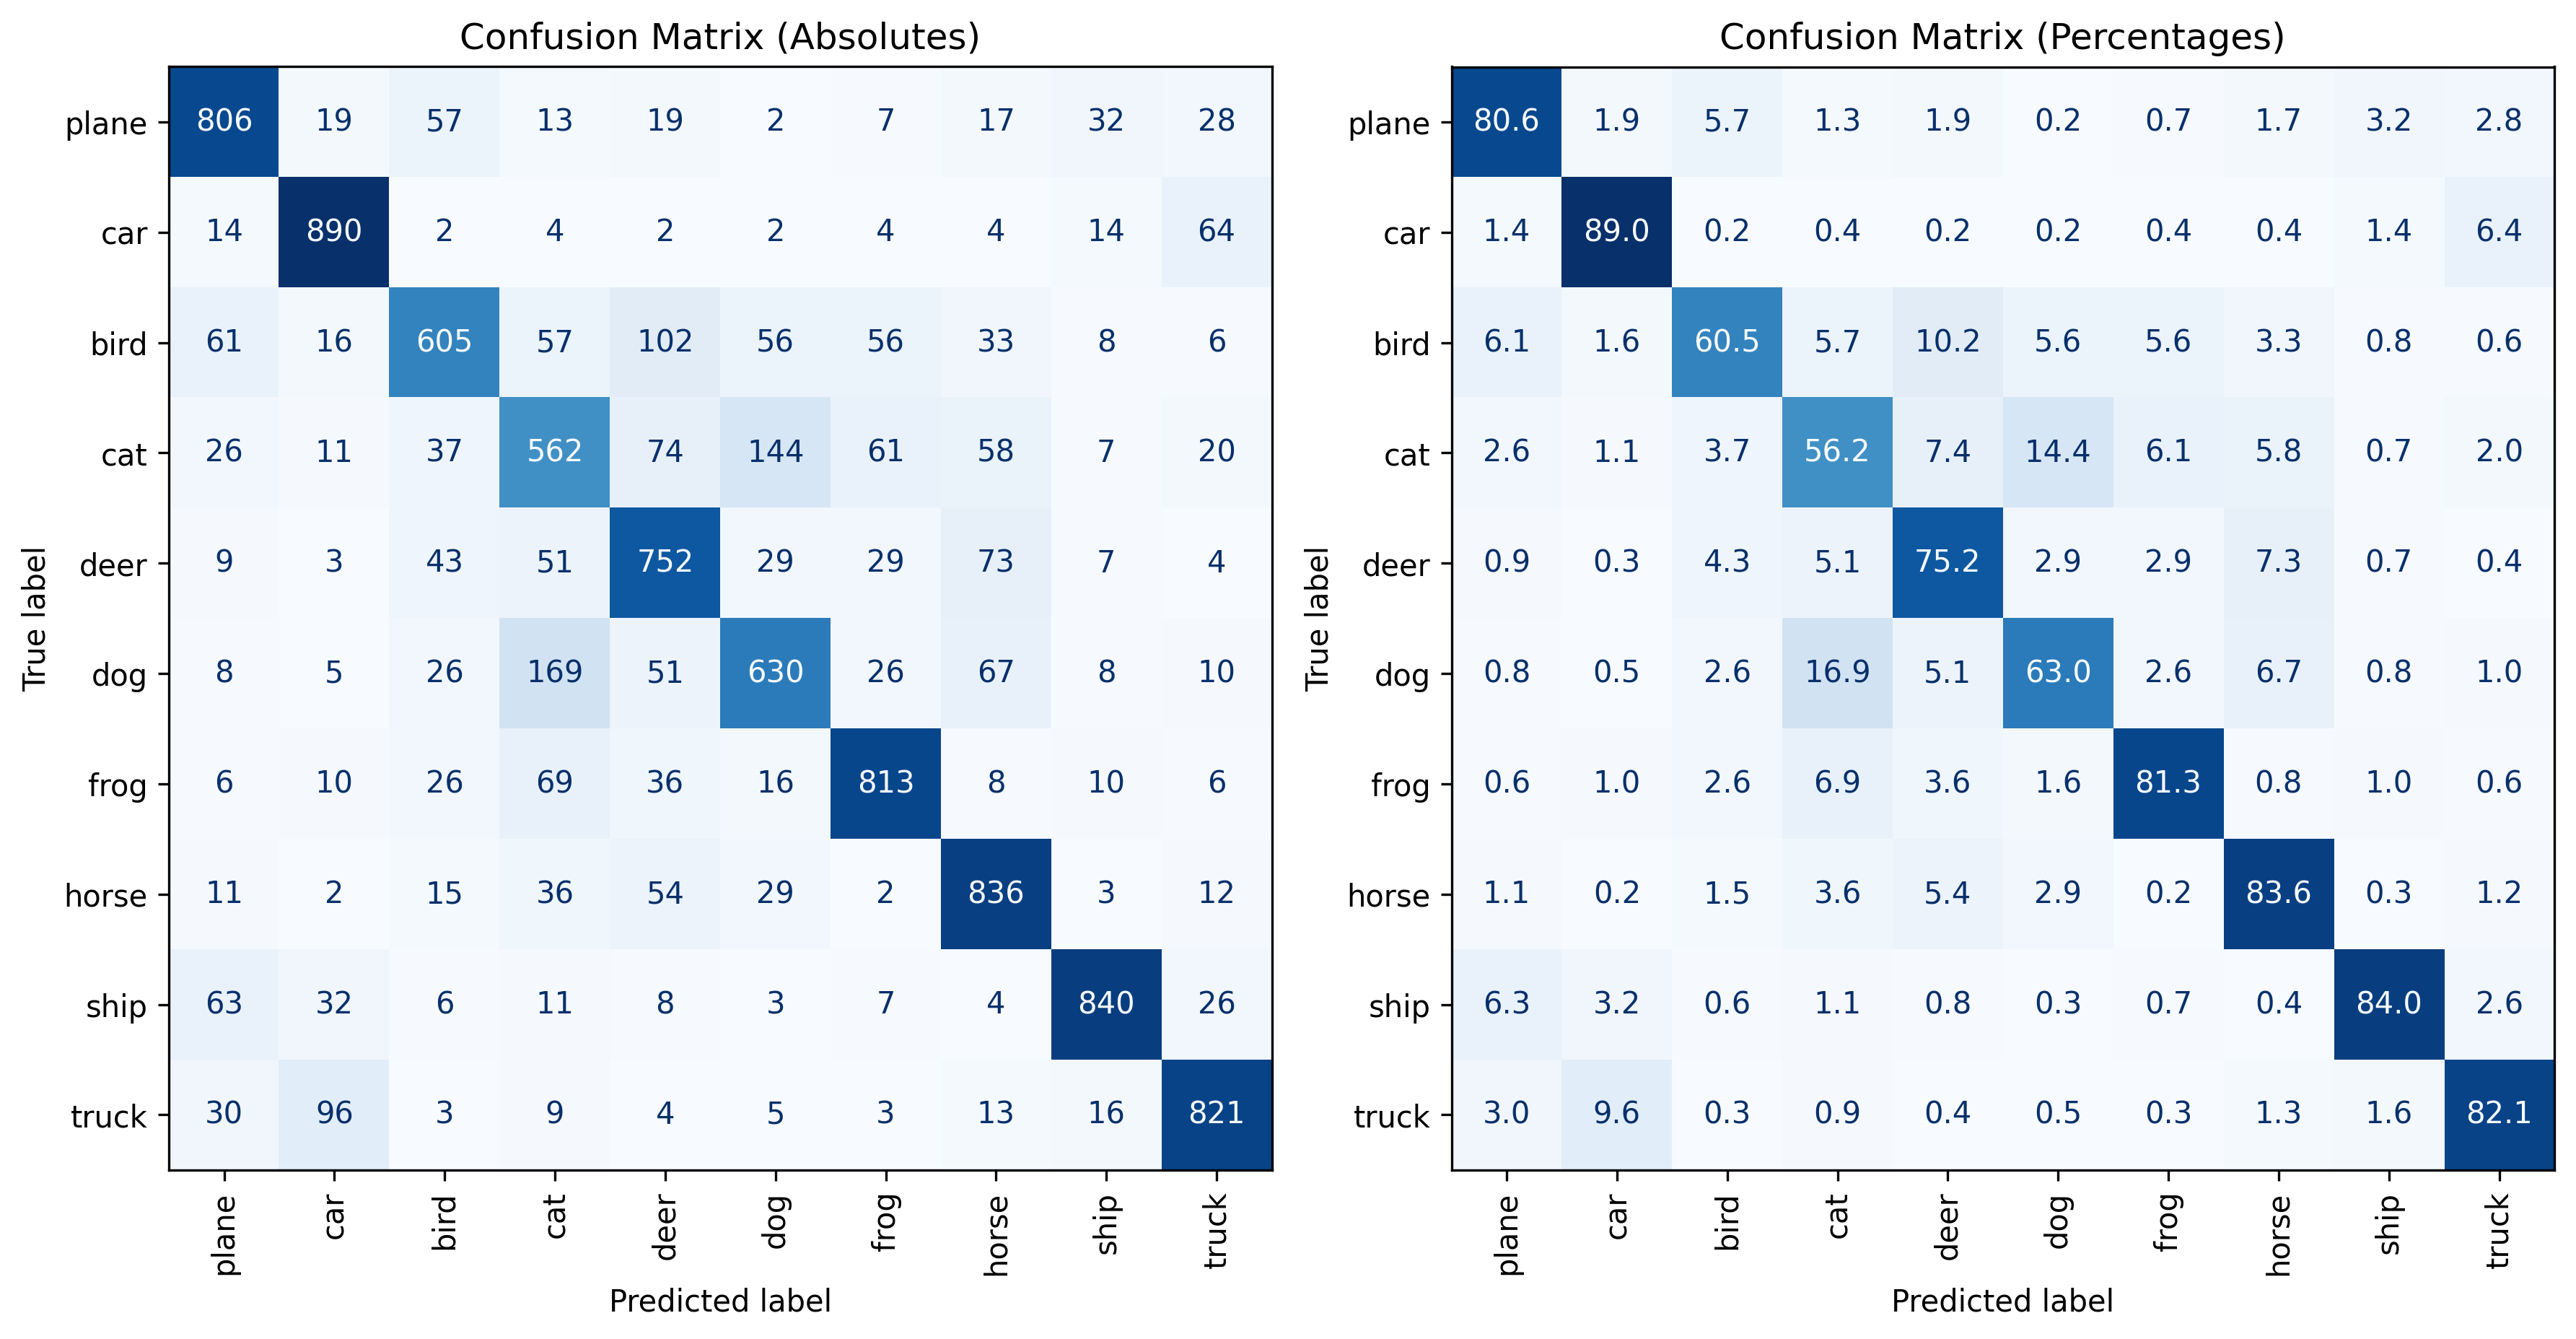

In [11]:
# Sklearn confusion matrix version 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
predictions_list = []
labels_list = []
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            else:
                # Store misclassified images and labels
                misclassified_images.append(images)
                misclassified_labels.append(classes[label])
                misclassified_predictions.append(classes[prediction])
                
            total_pred[classes[label]] += 1
            predictions_list.append(prediction.item())
            labels_list.append(label.item())

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_list, predictions_list)

###################################
# plot conf_matrix and percentage #
###################################

fig, axs = plt.subplots(1, 2, figsize=(12, 8), dpi=300)

# Plot confusion matrix (Absolutes)
axs[0].set_title('Confusion Matrix (Absolutes)')
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=classes)
cm_display.plot(cmap='Blues', ax=axs[0], values_format='.0f', colorbar=False, xticks_rotation='vertical')
axs[0].grid(False) 

# Plot confusion matrix (percentages)
row_sum = np.sum(conf_matrix, axis=1, keepdims=True)
conf_matrix_percentage = (conf_matrix / row_sum) * 100
axs[1].set_title('Confusion Matrix (Percentages)')
cm_display = ConfusionMatrixDisplay(conf_matrix_percentage, display_labels=classes)
cm_display.plot(cmap='Blues', ax=axs[1], values_format='.1f', colorbar=False, xticks_rotation='vertical')
axs[1].grid(False) 

plt.tight_layout()
#plt.savefig('2.png', dpi = 300)   # Saves
plt.show()

In [190]:
import random

# Given a ground truth class and a (different) predicted class, gives back four random 
# indexes from the misclassified_images where that misclassification ocurred

def idx_finder (gt, classification):
    indexes = []
    for index, (item1, item2) in enumerate(zip(misclassified_labels, misclassified_predictions)):
        if item1 == gt and item2 == classification:
            indexes.append(index)
    return random.sample(indexes, 4)

# Example:
idx_finder("plane","bird")

[1160, 1919, 1559, 193]

The real label was: bird, was classified as: deer


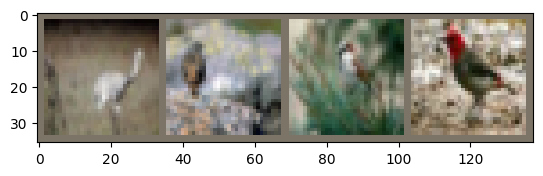

In [191]:
idxs = idx_finder("bird","deer")

images = []
for i in idxs:
    images.append(misclassified_images[i][0])

# Prints 4 choosen misclassification employing prevously defined functions
imshow(torchvision.utils.make_grid(images))
print(f"The real label was: {misclassified_labels[idxs[0]]}, was classified as: {misclassified_predictions[idxs[0]]}")

The real label was: cat, was classified as: dog


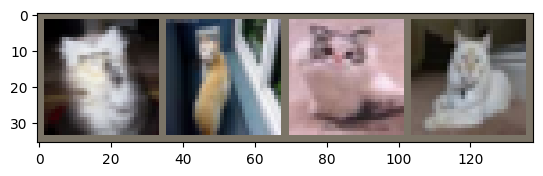

In [206]:
idxs = idx_finder("cat","dog")

images = []
for i in idxs:
    images.append(misclassified_images[i][0])

imshow(torchvision.utils.make_grid(images))
print(f"The real label was: {misclassified_labels[idxs[0]]}, was classified as: {misclassified_predictions[idxs[0]]}")

The real label was: dog, was classified as: cat


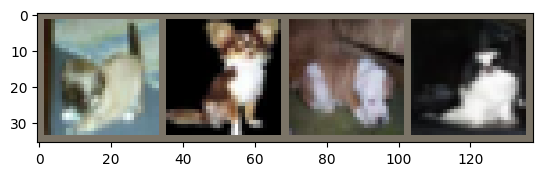

In [129]:
idxs = idx_finder("dog","cat")

images = []
for i in idxs:
    images.append(misclassified_images[i][0])

imshow(torchvision.utils.make_grid(images))
print(f"The real label was: {misclassified_labels[idxs[0]]}, was classified as: {misclassified_predictions[idxs[0]]}")

The real label was: truck, was classified as: car


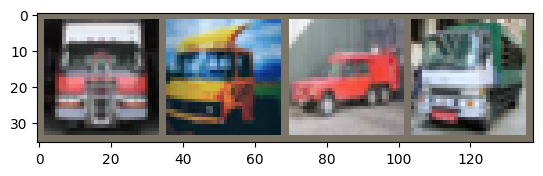

In [131]:
idxs = idx_finder("truck","car")

images = []
for i in idxs:
    images.append(misclassified_images[i][0])

imshow(torchvision.utils.make_grid(images))
print(f"The real label was: {misclassified_labels[idxs[0]]}, was classified as: {misclassified_predictions[idxs[0]]}")

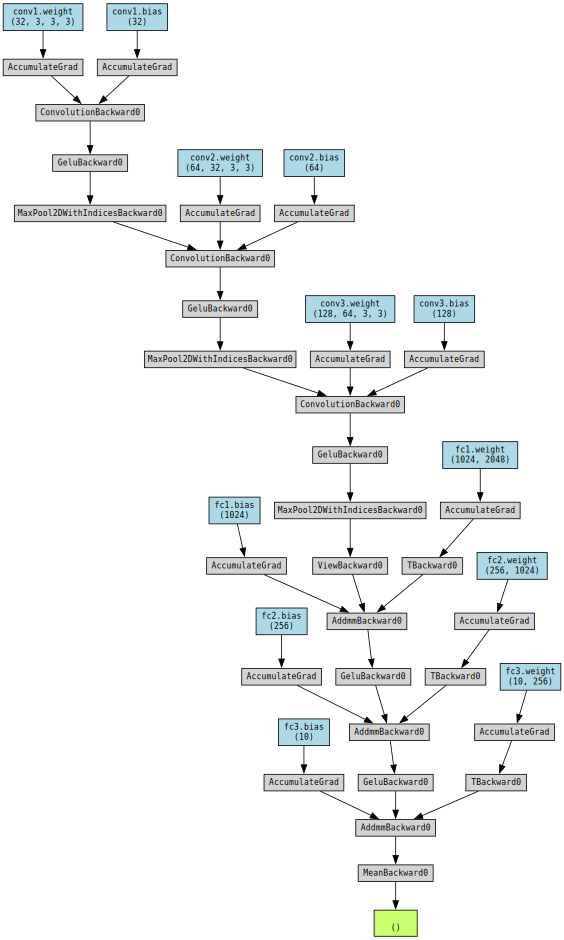

In [209]:
from torchviz import make_dot

# Graphical representation of our CNN with a dummy input.
# Unfortunatly not enough space on the lab report for this

x = torch.randn(4, 3, 32, 32)
y = net(x)

graph = make_dot(y.mean(), params=dict(net.named_parameters()), show_attrs=False, show_saved=False)
graph
#graph.render("network_graph", format="png")